### Project Objective
The project aims to predict customer churn for a subscription-based service, such as a telecommunications company, using machine learning techniques. Customer churn refers to the phenomenon where customers discontinue their subscription or stop using the service. By identifying customers at risk of churn, the company can take proactive measures to retain them, such as offering incentives or personalized promotions.


# **Step 1: Import Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# **Step 2: Load the Dataset**

In [ ]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Step 3: Exploratory Data Analysis (EDA)**

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## **Churn Count**

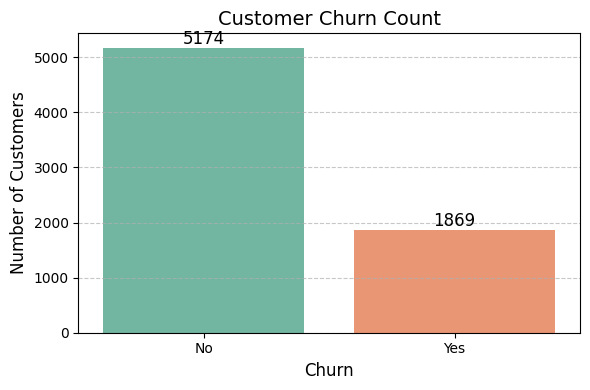

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df, hue='Churn', palette='Set2', legend=False)

for p in ax.patches:
    height = int(p.get_height())  # Convert to integer to remove decimal
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black')

plt.title('Customer Churn Count', fontsize=14)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Contract Type vs Churn

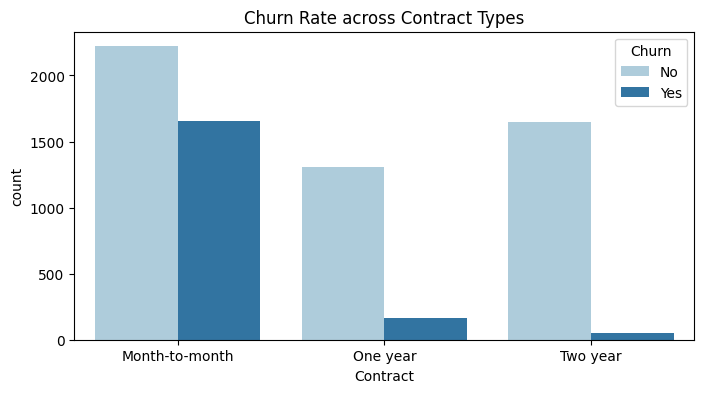

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Contract', hue='Churn', data=df, palette='Paired')
plt.title('Churn Rate across Contract Types')
plt.show()

## **Tenure Distribution**

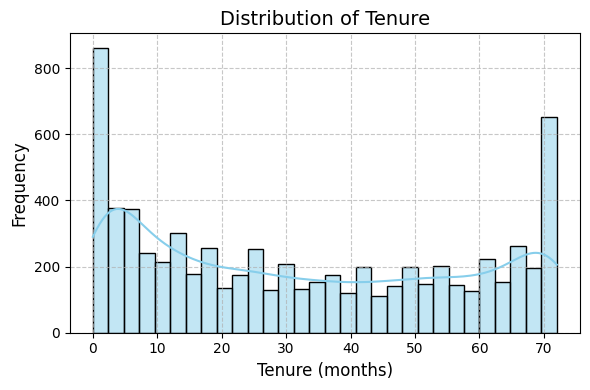

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df['tenure'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Tenure', fontsize=14)
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Churn rate by Internet Service Type

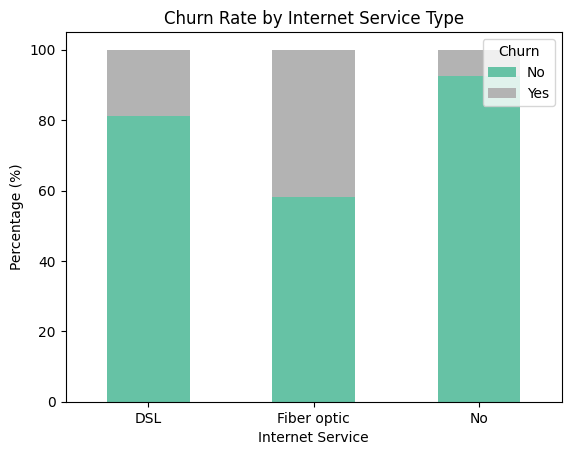

Churn % by Internet Service Type:
Churn                   No        Yes
InternetService                      
DSL              81.040892  18.959108
Fiber optic      58.107235  41.892765
No               92.595020   7.404980


In [ ]:
internet_churn = df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack() * 100

internet_churn.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Churn Rate by Internet Service Type")
plt.ylabel("Percentage (%)")
plt.xlabel("Internet Service")
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='upper right')
plt.show()

# Actual churn percentages
print("Churn % by Internet Service Type:")
print(internet_churn)

# **Step 4: Clean the Data**

In [ ]:
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

df['TotalCharges'] = df['TotalCharges'].astype(float)

df.drop("customerID", axis=1, inplace=True)

# **Step 5: Encode Categorical Variables**

In [ ]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
label_encoders = {}

for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-hot encode remaining categorical columns
df = pd.get_dummies(df, drop_first=True)

df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,False,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,True,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,True,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,True,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,False,...,False,False,False,False,False,False,False,False,True,False


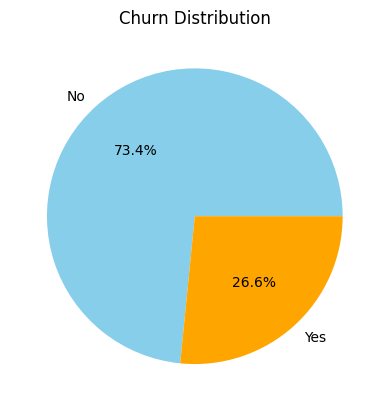

In [ ]:
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', labels=['No', 'Yes'], colors=['skyblue', 'orange'])
plt.title('Churn Distribution')
plt.ylabel('')
plt.show()

# **Step 6 & 7 Combined: Handle Class Imbalance and Scale:** **Features**

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Check balance
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Show result
pd.DataFrame(X_scaled, columns=X.columns).head()

Class distribution after SMOTE:
Churn
0    5163
1    5163
Name: count, dtype: int64


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Male,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.395546,1.288664,-0.521975,-1.118287,-2.928967,0.824195,-1.340972,-0.927918,-1.151380,2.928967,...,-0.631512,-0.447214,-0.903172,-0.447214,-0.903172,-0.486616,-0.461794,-0.526479,1.034088,-0.547585
1,-0.395546,-0.775998,-0.521975,0.262264,0.341417,-1.213305,-0.394185,-0.074949,0.868523,-0.341417,...,-0.631512,-0.447214,-0.903172,-0.447214,-0.903172,2.055010,-0.461794,-0.526479,-0.967035,1.826202
2,-0.395546,-0.775998,-0.521975,-1.076452,0.341417,0.824195,-0.502489,-0.892004,0.868523,-0.341417,...,-0.631512,-0.447214,-0.903172,-0.447214,-0.903172,-0.486616,-0.461794,-0.526479,-0.967035,1.826202
3,-0.395546,-0.775998,-0.521975,0.722448,-2.928967,-1.213305,-0.906009,-0.097309,0.868523,2.928967,...,1.583500,-0.447214,-0.903172,-0.447214,-0.903172,2.055010,-0.461794,-0.526479,-0.967035,-0.547585
4,-0.395546,-0.775998,-0.521975,-1.076452,0.341417,0.824195,0.086196,-0.872052,-1.151380,-0.341417,...,-0.631512,-0.447214,-0.903172,-0.447214,-0.903172,-0.486616,-0.461794,-0.526479,1.034088,-0.547585


# **Step 8: Split the Dataset**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    #"Naive Bayes": GaussianNB(),
    #"KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# **Step 9: Train  Models**




In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion": confusion_matrix(y_test, y_pred)
    }

# Top 2 models based on accuracy
top_2_models = sorted(results.items(), key=lambda x: x[1]['Accuracy'], reverse=True)[:2]

# Model Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}
xgb_model = XGBClassifier(eval_metric='logloss', verbosity=0)
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                    scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best Accuracy: 0.8440671179074205


# **Step 10: Evaluation**


Model: Random Forest
Accuracy: 0.8451
Confusion Matrix:
[[858 175]
 [145 888]]
Classification Report:
              precision    recall  f1-score      support
0              0.855434  0.830591  0.842829  1033.000000
1              0.835372  0.859632  0.847328  1033.000000
accuracy       0.845111  0.845111  0.845111     0.845111
macro avg      0.845403  0.845111  0.845079  2066.000000
weighted avg   0.845403  0.845111  0.845079  2066.000000




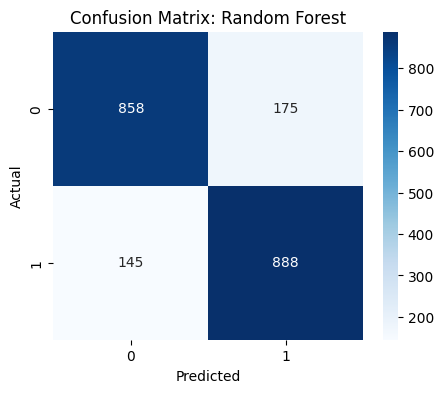

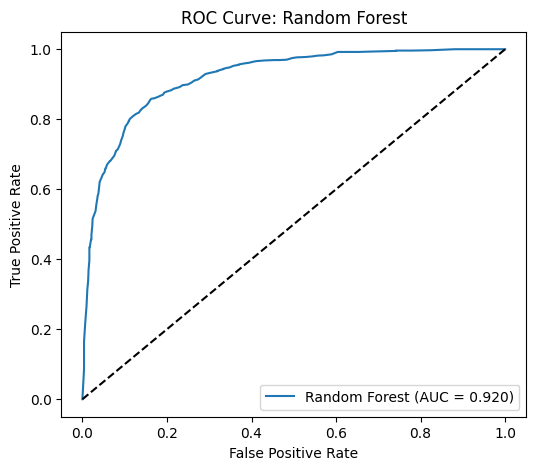


Model: XGBoost
Accuracy: 0.8330
Confusion Matrix:
[[843 190]
 [155 878]]
Classification Report:
              precision    recall  f1-score      support
0              0.844689  0.816070  0.830133  1033.000000
1              0.822097  0.849952  0.835792  1033.000000
accuracy       0.833011  0.833011  0.833011     0.833011
macro avg      0.833393  0.833011  0.832963  2066.000000
weighted avg   0.833393  0.833011  0.832963  2066.000000




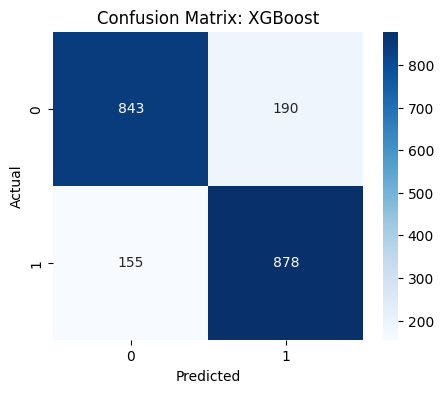

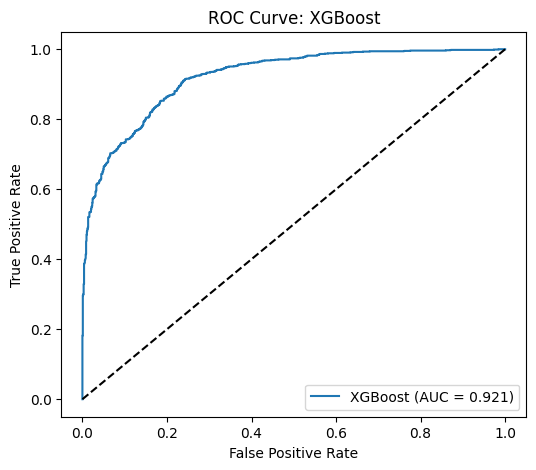

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, result in top_2_models:
    model = models[model_name]

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Confusion Matrix:")
    print(result['Confusion'])
    print("Classification Report:")
    print(pd.DataFrame(result['Report']).transpose())

    # Confusion matrix heatmap
    print("\n")
    plt.figure(figsize=(5, 4))
    sns.heatmap(result['Confusion'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    print("\n")
    plt.figure(figsize=(6, 5))
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# **Step 11: Visualize Feature Importance (Random Forest)**

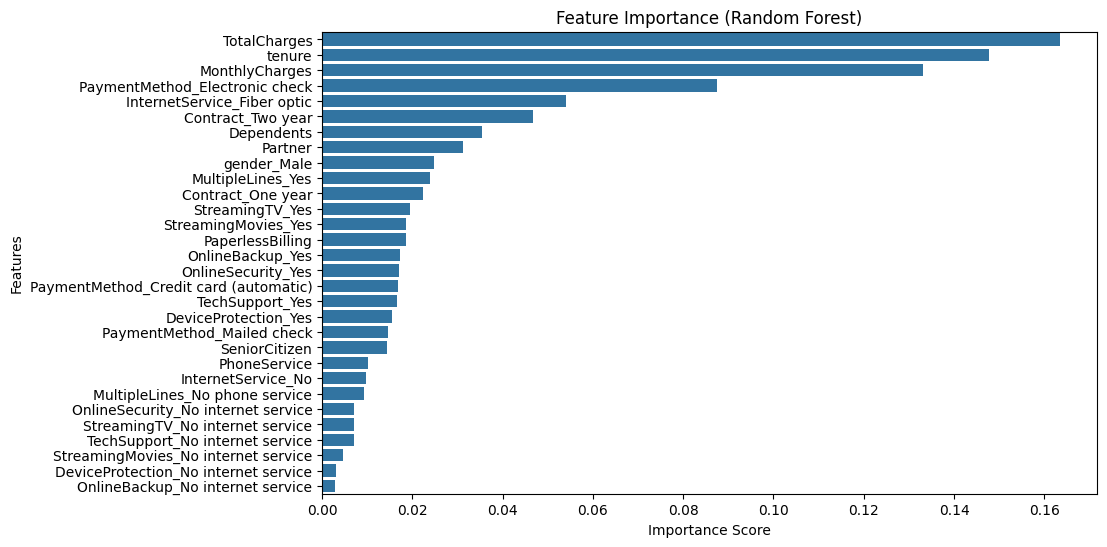

In [ ]:
importances = models["Random Forest"].feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [ ]:
df.to_csv("processed_churn_predictions.csv", index=False)

In [ ]:
from google.colab import files
files.download("processed_churn_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np

y_pred = model.predict(X_test)
predicted_labels = np.where(y_pred == 1, "Yes", "No")
actual_labels = np.where(y_test == 1, "Yes", "No")

X_test_original = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns)
X_test_original["ActualChurned"] = actual_labels
X_test_original["PredictedChurned"] = predicted_labels

X_test_original.to_csv("clean_predicted_churn.csv", index=False)

from google.colab import files
files.download("clean_predicted_churn.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Key Insights & Business Recommendations

### Key Insights:

-  Month-to-month customers have higher churn rates compared to longer-term customers.
- Fiber optic users have higher churn rates compared to DSL users.
- Users with higher monthly charges are more likely to churn.
- Online security, tech support and device protection are all strongly associated with churn.
- Shorter tenured customers (<12 months) incur greater churn risks.

---

### Recommendations for Business Action:

- Promote long-term contracts with month-to-month clients using discounted pricing or discount incentives.
- Bundle general security, online security, tech support, or other essential services into base plans or a limited-time “free” trial.
- Provide loyalty programs or cashback for clients with high monthly fees.
- Use churn prediction scoring to identify those customers at risk for churn, and provide retention strategies to these customers like personalized offers or reaching out with a call.
- Execute onboarding campaigns for new customers to create a better experience for them in the beginning stage and reduce early churn.

---

These insights will allow the business to pinpoint which drivers are causing churn and help develop effective retention strategies based on data.
